In [95]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np
import timeit 
import os
from datetime import datetime
from datetime import timedelta


#NB : timeit.default_timer() auto chooses timeing function for os, nicer than time.time() or time.clock()
print ("libraries imported")

libraries imported


In [2]:
start_time = timeit.default_timer()
df1 = pd.read_csv('PD1.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.2448402591795173


In [3]:
start_time = timeit.default_timer()
df2 = pd.read_csv('PD2.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  2.960270469755583


In [4]:
df = df1.set_index('TimeStamp').join(df2.set_index('TimeStamp'))

In [5]:
df.shape

(60000, 792)

In [32]:
start_time = timeit.default_timer()
print ("start loading data")
dfOD = pd.read_csv('OD.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
print (dfOD.shape)
print (dfOD.head())
print (type(dfOD['Start'][0]))

start loading data
elapsed time :  0.004583924101552839
(1000, 4)
              Start            Finish               AACodeDesc  \
0  29/07/2015 23:30   30/07/2015 3:34        Operational Stops   
1  20/03/2015 13:52  20/03/2015 13:55  Unscheduled Maintenance   
2   7/10/2013 22:14   7/10/2013 22:27        Operational Stops   
3   28/01/2013 9:28  28/01/2013 10:15                   Delays   
4  14/04/2016 12:15  14/04/2016 12:21        Operational Stops   

                                  FailureMode  
0                   Pre-Drying tower low flow  
1                                   Feed pots  
2  ESD LP cooling system temperatures / flows  
3                       Metallurgist testwork  
4  ESD LP cooling system temperatures / flows  
<class 'str'>


In [33]:
start_time = timeit.default_timer()
#suppress warning
#refer https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
#https://pandas.pydata.org/pandas-docs/stable/options.html
#pd.options.mode.chained_assignment = None or 'warn'
pd.options.mode.chained_assignment = None
print ("start")
dfOD["duration"] = np.nan
dfOD["Start_"] = np.nan
dfOD["Finish_"] = np.nan
for i in range(dfOD.shape[0]):
    tempFinish = datetime.strptime(dfOD['Finish'][i], '%d/%m/%Y %H:%M')
    #print ("type(tempFinish):", type(tempFinish))
    tempStart = datetime.strptime(dfOD['Start'][i], '%d/%m/%Y %H:%M')
    #print ("type(tempStart):", type(tempStart))
    dfOD['duration'][i] = (tempFinish - tempStart).total_seconds()
    #print (type(df1['duration'][i]))
    dfOD['Finish_'][i] = tempFinish
    dfOD['Start_'][i] = tempStart
    
    #df1["durationSeconds"][i] = (df1['duration'][i]-datetime(1970,1,1)).total_seconds()
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
print (dfOD.head())

start
elapsed time :  0.3189404680635448
              Start            Finish               AACodeDesc  \
0  29/07/2015 23:30   30/07/2015 3:34        Operational Stops   
1  20/03/2015 13:52  20/03/2015 13:55  Unscheduled Maintenance   
2   7/10/2013 22:14   7/10/2013 22:27        Operational Stops   
3   28/01/2013 9:28  28/01/2013 10:15                   Delays   
4  14/04/2016 12:15  14/04/2016 12:21        Operational Stops   

                                  FailureMode  duration               Start_  \
0                   Pre-Drying tower low flow   14640.0  2015-07-29 23:30:00   
1                                   Feed pots     180.0  2015-03-20 13:52:00   
2  ESD LP cooling system temperatures / flows     780.0  2013-10-07 22:14:00   
3                       Metallurgist testwork    2820.0  2013-01-28 09:28:00   
4  ESD LP cooling system temperatures / flows     360.0  2016-04-14 12:15:00   

               Finish_  
0  2015-07-30 03:34:00  
1  2015-03-20 13:55:00  
2  201

In [34]:
#drop NAN values
master_feed_rate = df['master_feed_rate'].dropna()
master_feed_rate.shape
#59963+37=60,000

(59963,)

In [35]:
master_feed_rate = master_feed_rate[master_feed_rate>=0]
print (master_feed_rate.shape)
print (master_feed_rate.min())
#59963=59939+24 : 24 values < zero removed.

(59939,)
0.0


In [36]:
print (master_feed_rate.head() )
print (type(master_feed_rate))

TimeStamp
2013-01-02 11:19:30    0.0
2013-01-02 12:53:00    0.0
2013-01-02 13:08:30    0.0
2013-01-02 13:34:00    0.0
2013-01-02 14:04:00    0.0
Name: master_feed_rate, dtype: float64
<class 'pandas.core.series.Series'>


In [37]:
master_feed_rate[0]

0.0

<IPython.core.display.Javascript object>


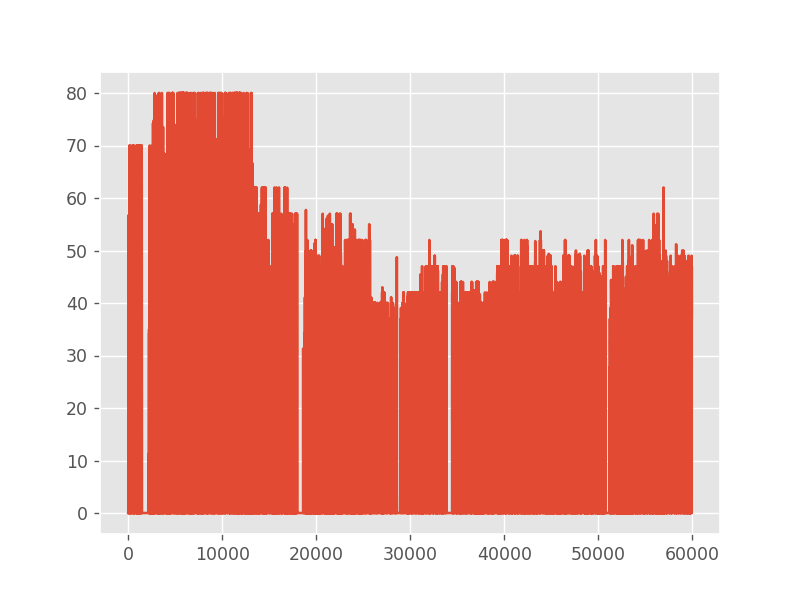

In [38]:
plt.figure()
plt.plot(list(master_feed_rate))

In [39]:
#now convert master_feed_rate dataset into schedule of start/stop times.
#loop through contents of master_feed_rate
# identify start of zero feedrate.
# continue until feedrate is non zero.
# extract and record start-time and stop-time of zero feedrate period.
# repeat until end
shutdownStart = 0
shtudownEnd = 0
running = False
#
dfStartStop = pd.DataFrame(columns=['Start','Stop', 'Duration'])
dfStartStopCounter = 0
dfStartStop.shape
list(dfStartStop)
#
i = 0
start_time = timeit.default_timer()
print ("at i=", i, ", master_feed_rate = ", master_feed_rate[i], ", timestamp =", master_feed_rate.index[i])
while not running and master_feed_rate[i]==0 and i<master_feed_rate.shape[0]-1:
    i += 1
running = True
#
print ("started at i=", i, ", master_feed_rate = ", master_feed_rate[i], ", timestamp =", master_feed_rate.index[i])
print ("start recording shutdowns")
#while i<100:
while i<master_feed_rate.shape[0]-1:
    while running and master_feed_rate[i]!=0 and i<master_feed_rate.shape[0]-1:
        i += 1
    running = False
    #print ("stopped at i=", i, ", master_feed_rate = ", master_feed_rate[i], ", timestamp =", master_feed_rate.index[i])
    start = master_feed_rate.index[i]
    while not running and master_feed_rate[i]==0 and i<master_feed_rate.shape[0]-1:
        i += 1
    running = True
    stop = master_feed_rate.index[i]
    print ("started at i=", i, ", master_feed_rate = ", master_feed_rate[i], ", timestamp =", stop)
    #convert strings to datetime format & calc duration (duration will be useful for checking data)
    #tempStart = datetime.strptime(df1['Start'][i], '%d/%m/%Y %H:%M')
    #df1['duration'][i] = (tempFinish - tempStart).total_seconds()
    start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S').replace(second=0, microsecond=0)
    stop = datetime.strptime(stop, '%Y-%m-%d %H:%M:%S').replace(second=0, microsecond=0)
    duration = (stop-start).total_seconds()
    print ("i=", i, "feed rate:", master_feed_rate[i], ", start:", start, ", stop:", stop, ", duration:", duration)
    dfStartStop = dfStartStop.append(pd.DataFrame([[start, stop, duration]], columns=['Start','Stop', 'Duration']), ignore_index=True)

    
print ("end")
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)


at i= 0 , master_feed_rate =  0.0 , timestamp = 2013-01-02 11:19:30
started at i= 31 , master_feed_rate =  18.12941 , timestamp = 2013-01-03 04:03:00
start recording shutdowns
started at i= 46 , master_feed_rate =  9.643151 , timestamp = 2013-01-03 12:45:30
i= 46 feed rate: 9.643151 , start: 2013-01-03 05:09:00 , stop: 2013-01-03 12:45:00 , duration: 27360.0
started at i= 52 , master_feed_rate =  3.521592 , timestamp = 2013-01-03 15:23:30
i= 52 feed rate: 3.521592 , start: 2013-01-03 13:30:00 , stop: 2013-01-03 15:23:00 , duration: 6780.0
started at i= 59 , master_feed_rate =  56.76749 , timestamp = 2013-01-03 19:41:00
i= 59 feed rate: 56.76749 , start: 2013-01-03 18:22:00 , stop: 2013-01-03 19:41:00 , duration: 4740.0
started at i= 63 , master_feed_rate =  50.35986 , timestamp = 2013-01-03 21:12:30
i= 63 feed rate: 50.35986 , start: 2013-01-03 20:45:00 , stop: 2013-01-03 21:12:00 , duration: 1620.0
started at i= 77 , master_feed_rate =  9.255472 , timestamp = 2013-01-04 02:16:00
i= 77

started at i= 856 , master_feed_rate =  15.0569 , timestamp = 2013-01-21 03:00:00
i= 856 feed rate: 15.0569 , start: 2013-01-21 02:32:00 , stop: 2013-01-21 03:00:00 , duration: 1680.0
started at i= 861 , master_feed_rate =  62.62478 , timestamp = 2013-01-21 06:12:00
i= 861 feed rate: 62.62478 , start: 2013-01-21 04:42:00 , stop: 2013-01-21 06:12:00 , duration: 5400.0
started at i= 863 , master_feed_rate =  52.48231 , timestamp = 2013-01-21 06:58:30
i= 863 feed rate: 52.48231 , start: 2013-01-21 06:28:00 , stop: 2013-01-21 06:58:00 , duration: 1800.0
started at i= 886 , master_feed_rate =  8.060594 , timestamp = 2013-01-21 14:21:00
i= 886 feed rate: 8.060594 , start: 2013-01-21 08:48:00 , stop: 2013-01-21 14:21:00 , duration: 19980.0
started at i= 902 , master_feed_rate =  42.61808 , timestamp = 2013-01-22 00:04:30
i= 902 feed rate: 42.61808 , start: 2013-01-21 23:02:00 , stop: 2013-01-22 00:04:00 , duration: 3720.0
started at i= 915 , master_feed_rate =  32.90627 , timestamp = 2013-01-

i= 3206 feed rate: 34.51893 , start: 2013-03-15 01:25:00 , stop: 2013-03-15 02:00:00 , duration: 2100.0
started at i= 3217 , master_feed_rate =  43.44852 , timestamp = 2013-03-15 05:12:30
i= 3217 feed rate: 43.44852 , start: 2013-03-15 04:01:00 , stop: 2013-03-15 05:12:00 , duration: 4260.0
started at i= 3232 , master_feed_rate =  47.88661 , timestamp = 2013-03-15 12:15:00
i= 3232 feed rate: 47.88661 , start: 2013-03-15 08:53:00 , stop: 2013-03-15 12:15:00 , duration: 12120.0
started at i= 3239 , master_feed_rate =  11.66026 , timestamp = 2013-03-15 14:50:00
i= 3239 feed rate: 11.66026 , start: 2013-03-15 13:26:00 , stop: 2013-03-15 14:50:00 , duration: 5040.0
started at i= 3254 , master_feed_rate =  68.95155 , timestamp = 2013-03-16 00:06:30
i= 3254 feed rate: 68.95155 , start: 2013-03-15 23:19:00 , stop: 2013-03-16 00:06:00 , duration: 2820.0
started at i= 3259 , master_feed_rate =  70.73776 , timestamp = 2013-03-16 01:44:30
i= 3259 feed rate: 70.73776 , start: 2013-03-16 00:43:00 , 

i= 4943 feed rate: 10.53903 , start: 2013-04-21 15:28:00 , stop: 2013-04-21 22:04:00 , duration: 23760.0
started at i= 4954 , master_feed_rate =  73.94054 , timestamp = 2013-04-22 04:04:30
i= 4954 feed rate: 73.94054 , start: 2013-04-22 00:24:00 , stop: 2013-04-22 04:04:00 , duration: 13200.0
started at i= 4959 , master_feed_rate =  55.79166 , timestamp = 2013-04-22 06:33:30
i= 4959 feed rate: 55.79166 , start: 2013-04-22 05:35:00 , stop: 2013-04-22 06:33:00 , duration: 3480.0
started at i= 5021 , master_feed_rate =  6.974069 , timestamp = 2013-04-23 15:25:00
i= 5021 feed rate: 6.974069 , start: 2013-04-22 08:57:00 , stop: 2013-04-23 15:25:00 , duration: 109680.0
started at i= 5024 , master_feed_rate =  45.52667 , timestamp = 2013-04-23 17:09:00
i= 5024 feed rate: 45.52667 , start: 2013-04-23 16:17:00 , stop: 2013-04-23 17:09:00 , duration: 3120.0
started at i= 5037 , master_feed_rate =  47.30114 , timestamp = 2013-04-24 00:00:00
i= 5037 feed rate: 47.30114 , start: 2013-04-23 21:41:00

i= 6639 feed rate: 63.93539 , start: 2013-05-29 14:28:00 , stop: 2013-05-29 17:15:00 , duration: 10020.0
started at i= 6677 , master_feed_rate =  53.43828 , timestamp = 2013-05-30 15:24:30
i= 6677 feed rate: 53.43828 , start: 2013-05-30 08:08:00 , stop: 2013-05-30 15:24:00 , duration: 26160.0
started at i= 6688 , master_feed_rate =  33.6287 , timestamp = 2013-05-30 19:55:00
i= 6688 feed rate: 33.6287 , start: 2013-05-30 19:41:00 , stop: 2013-05-30 19:55:00 , duration: 840.0
started at i= 6698 , master_feed_rate =  10.25347 , timestamp = 2013-05-31 04:10:30
i= 6698 feed rate: 10.25347 , start: 2013-05-30 23:55:00 , stop: 2013-05-31 04:10:00 , duration: 15300.0
started at i= 6705 , master_feed_rate =  13.26744 , timestamp = 2013-05-31 07:59:30
i= 6705 feed rate: 13.26744 , start: 2013-05-31 07:58:00 , stop: 2013-05-31 07:59:00 , duration: 60.0
started at i= 6710 , master_feed_rate =  4.223416 , timestamp = 2013-05-31 10:32:30
i= 6710 feed rate: 4.223416 , start: 2013-05-31 08:12:00 , sto

i= 8468 feed rate: 67.14418 , start: 2013-07-09 15:00:00 , stop: 2013-07-09 17:08:00 , duration: 7680.0
started at i= 8477 , master_feed_rate =  69.91532 , timestamp = 2013-07-10 00:10:00
i= 8477 feed rate: 69.91532 , start: 2013-07-09 22:24:00 , stop: 2013-07-10 00:10:00 , duration: 6360.0
started at i= 8494 , master_feed_rate =  45.47727 , timestamp = 2013-07-10 08:26:30
i= 8494 feed rate: 45.47727 , start: 2013-07-10 07:23:00 , stop: 2013-07-10 08:26:00 , duration: 3780.0
started at i= 8536 , master_feed_rate =  42.79466 , timestamp = 2013-07-11 06:10:00
i= 8536 feed rate: 42.79466 , start: 2013-07-10 10:01:00 , stop: 2013-07-11 06:10:00 , duration: 72540.0
started at i= 8634 , master_feed_rate =  24.06221 , timestamp = 2013-07-13 07:22:00
i= 8634 feed rate: 24.06221 , start: 2013-07-11 10:08:00 , stop: 2013-07-13 07:22:00 , duration: 162840.0
started at i= 8646 , master_feed_rate =  23.16503 , timestamp = 2013-07-13 15:20:00
i= 8646 feed rate: 23.16503 , start: 2013-07-13 14:00:00 

i= 10890 feed rate: 50.26284 , start: 2013-08-31 23:49:00 , stop: 2013-09-01 01:50:00 , duration: 7260.0
started at i= 10896 , master_feed_rate =  52.96068 , timestamp = 2013-09-01 03:52:00
i= 10896 feed rate: 52.96068 , start: 2013-09-01 02:34:00 , stop: 2013-09-01 03:52:00 , duration: 4680.0
started at i= 10899 , master_feed_rate =  67.84547 , timestamp = 2013-09-01 06:18:00
i= 10899 feed rate: 67.84547 , start: 2013-09-01 04:57:00 , stop: 2013-09-01 06:18:00 , duration: 4860.0
started at i= 10933 , master_feed_rate =  40.02526 , timestamp = 2013-09-01 21:12:00
i= 10933 feed rate: 40.02526 , start: 2013-09-01 07:23:00 , stop: 2013-09-01 21:12:00 , duration: 49740.0
started at i= 10958 , master_feed_rate =  36.96333 , timestamp = 2013-09-02 11:24:30
i= 10958 feed rate: 36.96333 , start: 2013-09-02 11:07:00 , stop: 2013-09-02 11:24:00 , duration: 1020.0
started at i= 10979 , master_feed_rate =  41.17066 , timestamp = 2013-09-02 20:27:00
i= 10979 feed rate: 41.17066 , start: 2013-09-02 

i= 12448 feed rate: 32.30031 , start: 2013-10-05 19:52:00 , stop: 2013-10-05 20:24:00 , duration: 1920.0
started at i= 12457 , master_feed_rate =  35.16833 , timestamp = 2013-10-06 00:42:30
i= 12457 feed rate: 35.16833 , start: 2013-10-06 00:08:00 , stop: 2013-10-06 00:42:00 , duration: 2040.0
started at i= 12467 , master_feed_rate =  33.63918 , timestamp = 2013-10-06 03:27:30
i= 12467 feed rate: 33.63918 , start: 2013-10-06 02:45:00 , stop: 2013-10-06 03:27:00 , duration: 2520.0
started at i= 12496 , master_feed_rate =  70.28322 , timestamp = 2013-10-06 14:58:00
i= 12496 feed rate: 70.28322 , start: 2013-10-06 12:37:00 , stop: 2013-10-06 14:58:00 , duration: 8460.0
started at i= 12504 , master_feed_rate =  63.30064 , timestamp = 2013-10-06 19:25:00
i= 12504 feed rate: 63.30064 , start: 2013-10-06 18:58:00 , stop: 2013-10-06 19:25:00 , duration: 1620.0
started at i= 12518 , master_feed_rate =  36.53384 , timestamp = 2013-10-07 03:19:30
i= 12518 feed rate: 36.53384 , start: 2013-10-07 0

started at i= 13995 , master_feed_rate =  0.2988024 , timestamp = 2013-11-08 03:42:30
i= 13995 feed rate: 0.2988024 , start: 2013-11-08 02:25:00 , stop: 2013-11-08 03:42:00 , duration: 4620.0
started at i= 14005 , master_feed_rate =  42.17282 , timestamp = 2013-11-08 10:09:30
i= 14005 feed rate: 42.17282 , start: 2013-11-08 06:16:00 , stop: 2013-11-08 10:09:00 , duration: 13980.0
started at i= 14014 , master_feed_rate =  2.536786 , timestamp = 2013-11-08 17:45:00
i= 14014 feed rate: 2.536786 , start: 2013-11-08 16:17:00 , stop: 2013-11-08 17:45:00 , duration: 5280.0
started at i= 14017 , master_feed_rate =  51.64685 , timestamp = 2013-11-08 18:05:30
i= 14017 feed rate: 51.64685 , start: 2013-11-08 17:53:00 , stop: 2013-11-08 18:05:00 , duration: 720.0
started at i= 14107 , master_feed_rate =  46.27922 , timestamp = 2013-11-10 17:31:30
i= 14107 feed rate: 46.27922 , start: 2013-11-08 18:32:00 , stop: 2013-11-10 17:31:00 , duration: 169140.0
started at i= 14114 , master_feed_rate =  42.0

started at i= 15462 , master_feed_rate =  49.28283 , timestamp = 2013-12-10 18:55:00
i= 15462 feed rate: 49.28283 , start: 2013-12-10 18:22:00 , stop: 2013-12-10 18:55:00 , duration: 1980.0
started at i= 15467 , master_feed_rate =  43.86964 , timestamp = 2013-12-10 21:24:30
i= 15467 feed rate: 43.86964 , start: 2013-12-10 20:26:00 , stop: 2013-12-10 21:24:00 , duration: 3480.0
started at i= 15480 , master_feed_rate =  47.0 , timestamp = 2013-12-11 03:44:00
i= 15480 feed rate: 47.0 , start: 2013-12-10 23:10:00 , stop: 2013-12-11 03:44:00 , duration: 16440.0
started at i= 15508 , master_feed_rate =  14.0 , timestamp = 2013-12-11 18:52:00
i= 15508 feed rate: 14.0 , start: 2013-12-11 05:01:00 , stop: 2013-12-11 18:52:00 , duration: 49860.0
started at i= 15511 , master_feed_rate =  36.1236 , timestamp = 2013-12-11 21:51:00
i= 15511 feed rate: 36.1236 , start: 2013-12-11 20:43:00 , stop: 2013-12-11 21:51:00 , duration: 4080.0
started at i= 15520 , master_feed_rate =  30.01196 , timestamp = 2

i= 16727 feed rate: 39.3744 , start: 2014-01-06 19:55:00 , stop: 2014-01-07 02:06:00 , duration: 22260.0
started at i= 16755 , master_feed_rate =  26.97004 , timestamp = 2014-01-07 18:55:00
i= 16755 feed rate: 26.97004 , start: 2014-01-07 09:21:00 , stop: 2014-01-07 18:55:00 , duration: 34440.0
started at i= 16777 , master_feed_rate =  42.0 , timestamp = 2014-01-08 03:56:30
i= 16777 feed rate: 42.0 , start: 2014-01-08 00:01:00 , stop: 2014-01-08 03:56:00 , duration: 14100.0
started at i= 16793 , master_feed_rate =  52.92365 , timestamp = 2014-01-08 10:49:00
i= 16793 feed rate: 52.92365 , start: 2014-01-08 09:35:00 , stop: 2014-01-08 10:49:00 , duration: 4440.0
started at i= 16817 , master_feed_rate =  30.49678 , timestamp = 2014-01-08 19:10:00
i= 16817 feed rate: 30.49678 , start: 2014-01-08 13:55:00 , stop: 2014-01-08 19:10:00 , duration: 18900.0
started at i= 16821 , master_feed_rate =  47.0 , timestamp = 2014-01-08 20:23:00
i= 16821 feed rate: 47.0 , start: 2014-01-08 19:54:00 , sto

i= 18943 feed rate: 4.545601 , start: 2014-02-26 07:05:00 , stop: 2014-02-26 07:51:00 , duration: 2760.0
started at i= 18953 , master_feed_rate =  4.02479 , timestamp = 2014-02-26 12:15:30
i= 18953 feed rate: 4.02479 , start: 2014-02-26 08:43:00 , stop: 2014-02-26 12:15:00 , duration: 12720.0
started at i= 18958 , master_feed_rate =  41.34121 , timestamp = 2014-02-26 16:44:00
i= 18958 feed rate: 41.34121 , start: 2014-02-26 14:30:00 , stop: 2014-02-26 16:44:00 , duration: 8040.0
started at i= 18970 , master_feed_rate =  42.0 , timestamp = 2014-02-27 01:48:30
i= 18970 feed rate: 42.0 , start: 2014-02-26 20:24:00 , stop: 2014-02-27 01:48:00 , duration: 19440.0
started at i= 18975 , master_feed_rate =  47.0 , timestamp = 2014-02-27 07:04:00
i= 18975 feed rate: 47.0 , start: 2014-02-27 04:19:00 , stop: 2014-02-27 07:04:00 , duration: 9900.0
started at i= 18982 , master_feed_rate =  18.57488 , timestamp = 2014-02-27 08:23:00
i= 18982 feed rate: 18.57488 , start: 2014-02-27 07:41:00 , stop: 

i= 20018 feed rate: 38.91727 , start: 2014-03-23 05:12:00 , stop: 2014-03-23 07:25:00 , duration: 7980.0
started at i= 20020 , master_feed_rate =  40.70399 , timestamp = 2014-03-23 09:26:30
i= 20020 feed rate: 40.70399 , start: 2014-03-23 08:49:00 , stop: 2014-03-23 09:26:00 , duration: 2220.0
started at i= 20023 , master_feed_rate =  32.0 , timestamp = 2014-03-23 09:52:00
i= 20023 feed rate: 32.0 , start: 2014-03-23 09:42:00 , stop: 2014-03-23 09:52:00 , duration: 600.0
started at i= 20040 , master_feed_rate =  37.45083 , timestamp = 2014-03-23 18:49:00
i= 20040 feed rate: 37.45083 , start: 2014-03-23 18:30:00 , stop: 2014-03-23 18:49:00 , duration: 1140.0
started at i= 20042 , master_feed_rate =  32.43962 , timestamp = 2014-03-23 22:16:00
i= 20042 feed rate: 32.43962 , start: 2014-03-23 20:20:00 , stop: 2014-03-23 22:16:00 , duration: 6960.0
started at i= 20049 , master_feed_rate =  29.54761 , timestamp = 2014-03-24 02:07:30
i= 20049 feed rate: 29.54761 , start: 2014-03-24 01:11:00 ,

i= 21258 feed rate: 16.85276 , start: 2014-04-20 17:20:00 , stop: 2014-04-20 17:27:00 , duration: 420.0
started at i= 21269 , master_feed_rate =  9.994914 , timestamp = 2014-04-21 00:42:30
i= 21269 feed rate: 9.994914 , start: 2014-04-21 00:18:00 , stop: 2014-04-21 00:42:00 , duration: 1440.0
started at i= 21274 , master_feed_rate =  17.5044 , timestamp = 2014-04-21 03:12:00
i= 21274 feed rate: 17.5044 , start: 2014-04-21 02:37:00 , stop: 2014-04-21 03:12:00 , duration: 2100.0
started at i= 21278 , master_feed_rate =  48.83158 , timestamp = 2014-04-21 05:37:00
i= 21278 feed rate: 48.83158 , start: 2014-04-21 04:59:00 , stop: 2014-04-21 05:37:00 , duration: 2280.0
started at i= 21288 , master_feed_rate =  52.75197 , timestamp = 2014-04-21 09:51:00
i= 21288 feed rate: 52.75197 , start: 2014-04-21 09:29:00 , stop: 2014-04-21 09:51:00 , duration: 1320.0
started at i= 21297 , master_feed_rate =  42.0 , timestamp = 2014-04-21 16:03:30
i= 21297 feed rate: 42.0 , start: 2014-04-21 15:13:00 , s

started at i= 22758 , master_feed_rate =  16.79642 , timestamp = 2014-05-24 03:31:30
i= 22758 feed rate: 16.79642 , start: 2014-05-24 02:48:00 , stop: 2014-05-24 03:31:00 , duration: 2580.0
started at i= 22764 , master_feed_rate =  22.08956 , timestamp = 2014-05-24 05:31:30
i= 22764 feed rate: 22.08956 , start: 2014-05-24 04:11:00 , stop: 2014-05-24 05:31:00 , duration: 4800.0
started at i= 22770 , master_feed_rate =  19.38479 , timestamp = 2014-05-24 11:49:00
i= 22770 feed rate: 19.38479 , start: 2014-05-24 07:58:00 , stop: 2014-05-24 11:49:00 , duration: 13860.0
started at i= 22773 , master_feed_rate =  37.0 , timestamp = 2014-05-24 16:38:00
i= 22773 feed rate: 37.0 , start: 2014-05-24 14:27:00 , stop: 2014-05-24 16:38:00 , duration: 7860.0
started at i= 22786 , master_feed_rate =  40.10041 , timestamp = 2014-05-25 01:00:00
i= 22786 feed rate: 40.10041 , start: 2014-05-25 00:47:00 , stop: 2014-05-25 01:00:00 , duration: 780.0
started at i= 22791 , master_feed_rate =  38.78396 , times

i= 24197 feed rate: 23.30884 , start: 2014-06-25 06:24:00 , stop: 2014-06-25 07:04:00 , duration: 2400.0
started at i= 24200 , master_feed_rate =  43.82638 , timestamp = 2014-06-25 08:18:00
i= 24200 feed rate: 43.82638 , start: 2014-06-25 08:03:00 , stop: 2014-06-25 08:18:00 , duration: 900.0
started at i= 24211 , master_feed_rate =  8.590776 , timestamp = 2014-06-25 14:18:00
i= 24211 feed rate: 8.590776 , start: 2014-06-25 10:50:00 , stop: 2014-06-25 14:18:00 , duration: 12480.0
started at i= 24214 , master_feed_rate =  7.0 , timestamp = 2014-06-25 15:36:30
i= 24214 feed rate: 7.0 , start: 2014-06-25 14:28:00 , stop: 2014-06-25 15:36:00 , duration: 4080.0
started at i= 24221 , master_feed_rate =  22.0 , timestamp = 2014-06-25 18:50:30
i= 24221 feed rate: 22.0 , start: 2014-06-25 16:41:00 , stop: 2014-06-25 18:50:00 , duration: 7740.0
started at i= 24229 , master_feed_rate =  16.09562 , timestamp = 2014-06-25 22:18:30
i= 24229 feed rate: 16.09562 , start: 2014-06-25 21:58:00 , stop: 20

i= 26950 feed rate: 32.0 , start: 2014-08-27 13:58:00 , stop: 2014-08-27 17:51:00 , duration: 13980.0
started at i= 26979 , master_feed_rate =  36.60244 , timestamp = 2014-08-28 13:08:00
i= 26979 feed rate: 36.60244 , start: 2014-08-28 08:34:00 , stop: 2014-08-28 13:08:00 , duration: 16440.0
started at i= 26988 , master_feed_rate =  40.0 , timestamp = 2014-08-28 17:42:30
i= 26988 feed rate: 40.0 , start: 2014-08-28 13:44:00 , stop: 2014-08-28 17:42:00 , duration: 14280.0
started at i= 27012 , master_feed_rate =  18.81842 , timestamp = 2014-08-29 08:43:30
i= 27012 feed rate: 18.81842 , start: 2014-08-29 08:30:00 , stop: 2014-08-29 08:43:00 , duration: 780.0
started at i= 27050 , master_feed_rate =  40.60442 , timestamp = 2014-08-30 01:43:30
i= 27050 feed rate: 40.60442 , start: 2014-08-30 01:05:00 , stop: 2014-08-30 01:43:00 , duration: 2280.0
started at i= 27070 , master_feed_rate =  9.693606 , timestamp = 2014-08-30 13:28:30
i= 27070 feed rate: 9.693606 , start: 2014-08-30 13:02:00 , 

i= 29750 feed rate: 36.16798 , start: 2014-10-28 06:45:00 , stop: 2014-10-28 08:38:00 , duration: 6780.0
started at i= 29761 , master_feed_rate =  38.92921 , timestamp = 2014-10-28 15:10:00
i= 29761 feed rate: 38.92921 , start: 2014-10-28 10:53:00 , stop: 2014-10-28 15:10:00 , duration: 15420.0
started at i= 29794 , master_feed_rate =  24.14396 , timestamp = 2014-10-29 10:49:00
i= 29794 feed rate: 24.14396 , start: 2014-10-29 07:56:00 , stop: 2014-10-29 10:49:00 , duration: 10380.0
started at i= 29809 , master_feed_rate =  40.10519 , timestamp = 2014-10-29 18:59:30
i= 29809 feed rate: 40.10519 , start: 2014-10-29 18:11:00 , stop: 2014-10-29 18:59:00 , duration: 2880.0
started at i= 29822 , master_feed_rate =  31.22641 , timestamp = 2014-10-30 03:18:30
i= 29822 feed rate: 31.22641 , start: 2014-10-30 01:50:00 , stop: 2014-10-30 03:18:00 , duration: 5280.0
started at i= 29848 , master_feed_rate =  13.86485 , timestamp = 2014-10-30 19:43:00
i= 29848 feed rate: 13.86485 , start: 2014-10-30

i= 31716 feed rate: 29.5836 , start: 2014-12-11 13:53:00 , stop: 2014-12-11 17:09:00 , duration: 11760.0
started at i= 31799 , master_feed_rate =  26.33159 , timestamp = 2014-12-13 17:00:30
i= 31799 feed rate: 26.33159 , start: 2014-12-11 20:45:00 , stop: 2014-12-13 17:00:00 , duration: 159300.0
started at i= 31810 , master_feed_rate =  17.0 , timestamp = 2014-12-13 20:55:00
i= 31810 feed rate: 17.0 , start: 2014-12-13 19:17:00 , stop: 2014-12-13 20:55:00 , duration: 5880.0
started at i= 31812 , master_feed_rate =  40.96082 , timestamp = 2014-12-13 21:27:00
i= 31812 feed rate: 40.96082 , start: 2014-12-13 21:21:00 , stop: 2014-12-13 21:27:00 , duration: 360.0
started at i= 31821 , master_feed_rate =  7.0 , timestamp = 2014-12-14 02:07:00
i= 31821 feed rate: 7.0 , start: 2014-12-14 00:06:00 , stop: 2014-12-14 02:07:00 , duration: 7260.0
started at i= 31832 , master_feed_rate =  35.60518 , timestamp = 2014-12-14 11:10:00
i= 31832 feed rate: 35.60518 , start: 2014-12-14 07:35:00 , stop: 2

started at i= 33567 , master_feed_rate =  17.0 , timestamp = 2015-01-23 06:41:00
i= 33567 feed rate: 17.0 , start: 2015-01-23 06:26:00 , stop: 2015-01-23 06:41:00 , duration: 900.0
started at i= 33572 , master_feed_rate =  29.5596 , timestamp = 2015-01-23 09:34:00
i= 33572 feed rate: 29.5596 , start: 2015-01-23 09:06:00 , stop: 2015-01-23 09:34:00 , duration: 1680.0
started at i= 33575 , master_feed_rate =  1.92005 , timestamp = 2015-01-23 11:07:00
i= 33575 feed rate: 1.92005 , start: 2015-01-23 11:03:00 , stop: 2015-01-23 11:07:00 , duration: 240.0
started at i= 33584 , master_feed_rate =  3.259214 , timestamp = 2015-01-23 15:44:30
i= 33584 feed rate: 3.259214 , start: 2015-01-23 15:15:00 , stop: 2015-01-23 15:44:00 , duration: 1740.0
started at i= 33748 , master_feed_rate =  21.9 , timestamp = 2015-01-27 01:29:30
i= 33748 feed rate: 21.9 , start: 2015-01-24 06:50:00 , stop: 2015-01-27 01:29:00 , duration: 239940.0
started at i= 33772 , master_feed_rate =  17.0 , timestamp = 2015-01-2

i= 36713 feed rate: 29.37362 , start: 2015-04-04 04:07:00 , stop: 2015-04-04 04:19:00 , duration: 720.0
started at i= 36716 , master_feed_rate =  37.0 , timestamp = 2015-04-04 05:14:30
i= 36716 feed rate: 37.0 , start: 2015-04-04 04:32:00 , stop: 2015-04-04 05:14:00 , duration: 2520.0
started at i= 36764 , master_feed_rate =  9.967183 , timestamp = 2015-04-05 11:09:00
i= 36764 feed rate: 9.967183 , start: 2015-04-05 09:23:00 , stop: 2015-04-05 11:09:00 , duration: 6360.0
started at i= 36773 , master_feed_rate =  36.9288 , timestamp = 2015-04-05 15:19:00
i= 36773 feed rate: 36.9288 , start: 2015-04-05 13:26:00 , stop: 2015-04-05 15:19:00 , duration: 6780.0
started at i= 36780 , master_feed_rate =  35.01007 , timestamp = 2015-04-05 18:08:30
i= 36780 feed rate: 35.01007 , start: 2015-04-05 17:15:00 , stop: 2015-04-05 18:08:00 , duration: 3180.0
started at i= 36786 , master_feed_rate =  32.0 , timestamp = 2015-04-05 23:41:00
i= 36786 feed rate: 32.0 , start: 2015-04-05 22:47:00 , stop: 201

i= 38468 feed rate: 34.0 , start: 2015-05-13 04:46:00 , stop: 2015-05-13 06:03:00 , duration: 4620.0
started at i= 38471 , master_feed_rate =  29.8716 , timestamp = 2015-05-13 07:53:00
i= 38471 feed rate: 29.8716 , start: 2015-05-13 07:50:00 , stop: 2015-05-13 07:53:00 , duration: 180.0
started at i= 38527 , master_feed_rate =  9.529199 , timestamp = 2015-05-14 06:19:30
i= 38527 feed rate: 9.529199 , start: 2015-05-13 08:19:00 , stop: 2015-05-14 06:19:00 , duration: 79200.0
started at i= 38540 , master_feed_rate =  23.55239 , timestamp = 2015-05-14 14:24:30
i= 38540 feed rate: 23.55239 , start: 2015-05-14 13:50:00 , stop: 2015-05-14 14:24:00 , duration: 2040.0
started at i= 38581 , master_feed_rate =  34.0 , timestamp = 2015-05-15 10:22:00
i= 38581 feed rate: 34.0 , start: 2015-05-15 09:09:00 , stop: 2015-05-15 10:22:00 , duration: 4380.0
started at i= 38599 , master_feed_rate =  17.0 , timestamp = 2015-05-15 20:48:00
i= 38599 feed rate: 17.0 , start: 2015-05-15 18:27:00 , stop: 2015-0

i= 40502 feed rate: 38.06763 , start: 2015-06-25 12:08:00 , stop: 2015-06-25 13:11:00 , duration: 3780.0
started at i= 40519 , master_feed_rate =  42.0 , timestamp = 2015-06-25 19:17:30
i= 40519 feed rate: 42.0 , start: 2015-06-25 17:53:00 , stop: 2015-06-25 19:17:00 , duration: 5040.0
started at i= 40532 , master_feed_rate =  22.4136 , timestamp = 2015-06-26 02:19:00
i= 40532 feed rate: 22.4136 , start: 2015-06-26 01:11:00 , stop: 2015-06-26 02:19:00 , duration: 4080.0
started at i= 40555 , master_feed_rate =  36.8004 , timestamp = 2015-06-26 14:15:30
i= 40555 feed rate: 36.8004 , start: 2015-06-26 14:14:00 , stop: 2015-06-26 14:15:00 , duration: 60.0
started at i= 40559 , master_feed_rate =  29.53079 , timestamp = 2015-06-26 17:10:00
i= 40559 feed rate: 29.53079 , start: 2015-06-26 16:52:00 , stop: 2015-06-26 17:10:00 , duration: 1080.0
started at i= 40597 , master_feed_rate =  40.83119 , timestamp = 2015-06-27 09:16:30
i= 40597 feed rate: 40.83119 , start: 2015-06-27 08:00:00 , stop

i= 42088 feed rate: 35.23804 , start: 2015-07-30 07:38:00 , stop: 2015-07-30 09:08:00 , duration: 5400.0
started at i= 42110 , master_feed_rate =  12.00118 , timestamp = 2015-07-30 19:05:30
i= 42110 feed rate: 12.00118 , start: 2015-07-30 18:10:00 , stop: 2015-07-30 19:05:00 , duration: 3300.0
started at i= 42113 , master_feed_rate =  46.54918 , timestamp = 2015-07-30 20:12:00
i= 42113 feed rate: 46.54918 , start: 2015-07-30 19:24:00 , stop: 2015-07-30 20:12:00 , duration: 2880.0
started at i= 42140 , master_feed_rate =  12.38762 , timestamp = 2015-07-31 10:21:30
i= 42140 feed rate: 12.38762 , start: 2015-07-31 04:46:00 , stop: 2015-07-31 10:21:00 , duration: 20100.0
started at i= 42152 , master_feed_rate =  37.00081 , timestamp = 2015-07-31 15:06:30
i= 42152 feed rate: 37.00081 , start: 2015-07-31 11:39:00 , stop: 2015-07-31 15:06:00 , duration: 12420.0
started at i= 42154 , master_feed_rate =  39.12719 , timestamp = 2015-07-31 16:03:30
i= 42154 feed rate: 39.12719 , start: 2015-07-31

i= 43840 feed rate: 27.25802 , start: 2015-09-06 14:44:00 , stop: 2015-09-06 14:53:00 , duration: 540.0
started at i= 43851 , master_feed_rate =  2.440793 , timestamp = 2015-09-06 21:38:00
i= 43851 feed rate: 2.440793 , start: 2015-09-06 21:12:00 , stop: 2015-09-06 21:38:00 , duration: 1560.0
started at i= 43886 , master_feed_rate =  37.15803 , timestamp = 2015-09-07 17:18:30
i= 43886 feed rate: 37.15803 , start: 2015-09-07 16:24:00 , stop: 2015-09-07 17:18:00 , duration: 3240.0
started at i= 43964 , master_feed_rate =  46.99565 , timestamp = 2015-09-09 11:32:00
i= 43964 feed rate: 46.99565 , start: 2015-09-09 10:59:00 , stop: 2015-09-09 11:32:00 , duration: 1980.0
started at i= 43972 , master_feed_rate =  46.78081 , timestamp = 2015-09-09 16:48:00
i= 43972 feed rate: 46.78081 , start: 2015-09-09 16:13:00 , stop: 2015-09-09 16:48:00 , duration: 2100.0
started at i= 43974 , master_feed_rate =  40.51199 , timestamp = 2015-09-09 18:29:30
i= 43974 feed rate: 40.51199 , start: 2015-09-09 17

i= 45541 feed rate: 21.38998 , start: 2015-10-14 15:07:00 , stop: 2015-10-14 15:33:00 , duration: 1560.0
started at i= 45557 , master_feed_rate =  26.1168 , timestamp = 2015-10-15 00:05:30
i= 45557 feed rate: 26.1168 , start: 2015-10-14 23:52:00 , stop: 2015-10-15 00:05:00 , duration: 780.0
started at i= 45562 , master_feed_rate =  12.0 , timestamp = 2015-10-15 00:48:00
i= 45562 feed rate: 12.0 , start: 2015-10-15 00:30:00 , stop: 2015-10-15 00:48:00 , duration: 1080.0
started at i= 45578 , master_feed_rate =  40.04878 , timestamp = 2015-10-15 13:10:00
i= 45578 feed rate: 40.04878 , start: 2015-10-15 12:09:00 , stop: 2015-10-15 13:10:00 , duration: 3660.0
started at i= 45584 , master_feed_rate =  38.79 , timestamp = 2015-10-15 15:04:30
i= 45584 feed rate: 38.79 , start: 2015-10-15 14:24:00 , stop: 2015-10-15 15:04:00 , duration: 2400.0
started at i= 45589 , master_feed_rate =  42.0 , timestamp = 2015-10-15 19:27:00
i= 45589 feed rate: 42.0 , start: 2015-10-15 18:39:00 , stop: 2015-10-1

i= 47282 feed rate: 37.70759 , start: 2015-11-21 15:10:00 , stop: 2015-11-21 16:15:00 , duration: 3900.0
started at i= 47287 , master_feed_rate =  39.46324 , timestamp = 2015-11-21 18:07:30
i= 47287 feed rate: 39.46324 , start: 2015-11-21 17:05:00 , stop: 2015-11-21 18:07:00 , duration: 3720.0
started at i= 47334 , master_feed_rate =  38.49602 , timestamp = 2015-11-22 14:33:30
i= 47334 feed rate: 38.49602 , start: 2015-11-22 02:56:00 , stop: 2015-11-22 14:33:00 , duration: 41820.0
started at i= 47364 , master_feed_rate =  38.60815 , timestamp = 2015-11-23 06:13:00
i= 47364 feed rate: 38.60815 , start: 2015-11-23 05:33:00 , stop: 2015-11-23 06:13:00 , duration: 2400.0
started at i= 47391 , master_feed_rate =  44.60759 , timestamp = 2015-11-23 20:27:30
i= 47391 feed rate: 44.60759 , start: 2015-11-23 19:34:00 , stop: 2015-11-23 20:27:00 , duration: 3180.0
started at i= 47406 , master_feed_rate =  18.9624 , timestamp = 2015-11-24 06:50:00
i= 47406 feed rate: 18.9624 , start: 2015-11-24 06

started at i= 49101 , master_feed_rate =  28.74477 , timestamp = 2015-12-31 19:56:00
i= 49101 feed rate: 28.74477 , start: 2015-12-30 02:05:00 , stop: 2015-12-31 19:56:00 , duration: 150660.0
started at i= 49122 , master_feed_rate =  39.24845 , timestamp = 2016-01-01 10:19:00
i= 49122 feed rate: 39.24845 , start: 2016-01-01 09:58:00 , stop: 2016-01-01 10:19:00 , duration: 1260.0
started at i= 49127 , master_feed_rate =  42.0 , timestamp = 2016-01-01 13:40:00
i= 49127 feed rate: 42.0 , start: 2016-01-01 12:55:00 , stop: 2016-01-01 13:40:00 , duration: 2700.0
started at i= 49130 , master_feed_rate =  43.57439 , timestamp = 2016-01-01 14:47:30
i= 49130 feed rate: 43.57439 , start: 2016-01-01 14:11:00 , stop: 2016-01-01 14:47:00 , duration: 2160.0
started at i= 49150 , master_feed_rate =  42.0 , timestamp = 2016-01-01 22:43:30
i= 49150 feed rate: 42.0 , start: 2016-01-01 22:25:00 , stop: 2016-01-01 22:43:00 , duration: 1080.0
started at i= 49166 , master_feed_rate =  42.0 , timestamp = 201

i= 50409 feed rate: 37.0 , start: 2016-01-30 15:06:00 , stop: 2016-01-30 23:36:00 , duration: 30600.0
started at i= 50412 , master_feed_rate =  27.56041 , timestamp = 2016-01-31 01:04:00
i= 50412 feed rate: 27.56041 , start: 2016-01-31 00:08:00 , stop: 2016-01-31 01:04:00 , duration: 3360.0
started at i= 50415 , master_feed_rate =  33.43798 , timestamp = 2016-01-31 03:30:30
i= 50415 feed rate: 33.43798 , start: 2016-01-31 03:22:00 , stop: 2016-01-31 03:30:00 , duration: 480.0
started at i= 50418 , master_feed_rate =  0.07920456 , timestamp = 2016-01-31 04:59:00
i= 50418 feed rate: 0.07920456 , start: 2016-01-31 04:50:00 , stop: 2016-01-31 04:59:00 , duration: 540.0
started at i= 50428 , master_feed_rate =  37.0 , timestamp = 2016-01-31 08:37:30
i= 50428 feed rate: 37.0 , start: 2016-01-31 08:10:00 , stop: 2016-01-31 08:37:00 , duration: 1620.0
started at i= 50440 , master_feed_rate =  42.0 , timestamp = 2016-01-31 15:35:00
i= 50440 feed rate: 42.0 , start: 2016-01-31 15:26:00 , stop: 2

started at i= 52115 , master_feed_rate =  31.06677 , timestamp = 2016-03-10 07:03:00
i= 52115 feed rate: 31.06677 , start: 2016-03-10 05:01:00 , stop: 2016-03-10 07:03:00 , duration: 7320.0
started at i= 52121 , master_feed_rate =  20.10959 , timestamp = 2016-03-10 08:54:30
i= 52121 feed rate: 20.10959 , start: 2016-03-10 08:37:00 , stop: 2016-03-10 08:54:00 , duration: 1020.0
started at i= 52142 , master_feed_rate =  34.7172 , timestamp = 2016-03-10 22:50:00
i= 52142 feed rate: 34.7172 , start: 2016-03-10 22:23:00 , stop: 2016-03-10 22:50:00 , duration: 1620.0
started at i= 52158 , master_feed_rate =  37.30799 , timestamp = 2016-03-11 08:47:00
i= 52158 feed rate: 37.30799 , start: 2016-03-11 05:51:00 , stop: 2016-03-11 08:47:00 , duration: 10560.0
started at i= 52169 , master_feed_rate =  40.63685 , timestamp = 2016-03-11 14:43:30
i= 52169 feed rate: 40.63685 , start: 2016-03-11 14:38:00 , stop: 2016-03-11 14:43:00 , duration: 300.0
started at i= 52173 , master_feed_rate =  12.0 , tim

i= 53093 feed rate: 47.0 , start: 2016-03-31 21:13:00 , stop: 2016-03-31 21:29:00 , duration: 960.0
started at i= 53097 , master_feed_rate =  47.0 , timestamp = 2016-04-01 01:09:00
i= 53097 feed rate: 47.0 , start: 2016-03-31 22:33:00 , stop: 2016-04-01 01:09:00 , duration: 9360.0
started at i= 53099 , master_feed_rate =  36.624 , timestamp = 2016-04-01 01:47:00
i= 53099 feed rate: 36.624 , start: 2016-04-01 01:12:00 , stop: 2016-04-01 01:47:00 , duration: 2100.0
started at i= 53139 , master_feed_rate =  12.0 , timestamp = 2016-04-01 22:06:00
i= 53139 feed rate: 12.0 , start: 2016-04-01 09:02:00 , stop: 2016-04-01 22:06:00 , duration: 47040.0
started at i= 53148 , master_feed_rate =  31.56469 , timestamp = 2016-04-02 01:09:00
i= 53148 feed rate: 31.56469 , start: 2016-04-01 22:49:00 , stop: 2016-04-02 01:09:00 , duration: 8400.0
started at i= 53154 , master_feed_rate =  42.0 , timestamp = 2016-04-02 07:12:00
i= 53154 feed rate: 42.0 , start: 2016-04-02 05:36:00 , stop: 2016-04-02 07:12

i= 54630 feed rate: 30.23629 , start: 2016-05-05 04:28:00 , stop: 2016-05-05 05:23:00 , duration: 3300.0
started at i= 54648 , master_feed_rate =  37.992 , timestamp = 2016-05-05 15:15:30
i= 54648 feed rate: 37.992 , start: 2016-05-05 07:09:00 , stop: 2016-05-05 15:15:00 , duration: 29160.0
started at i= 54652 , master_feed_rate =  41.00399 , timestamp = 2016-05-05 16:36:00
i= 54652 feed rate: 41.00399 , start: 2016-05-05 15:40:00 , stop: 2016-05-05 16:36:00 , duration: 3360.0
started at i= 54686 , master_feed_rate =  22.494 , timestamp = 2016-05-06 12:14:30
i= 54686 feed rate: 22.494 , start: 2016-05-06 12:01:00 , stop: 2016-05-06 12:14:00 , duration: 780.0
started at i= 54691 , master_feed_rate =  24.804 , timestamp = 2016-05-06 14:13:30
i= 54691 feed rate: 24.804 , start: 2016-05-06 13:46:00 , stop: 2016-05-06 14:13:00 , duration: 1620.0
started at i= 54701 , master_feed_rate =  24.83645 , timestamp = 2016-05-06 19:25:30
i= 54701 feed rate: 24.83645 , start: 2016-05-06 15:37:00 , st

started at i= 56339 , master_feed_rate =  47.0 , timestamp = 2016-06-12 17:59:30
i= 56339 feed rate: 47.0 , start: 2016-06-12 17:23:00 , stop: 2016-06-12 17:59:00 , duration: 2160.0
started at i= 56343 , master_feed_rate =  47.0 , timestamp = 2016-06-12 19:33:30
i= 56343 feed rate: 47.0 , start: 2016-06-12 18:50:00 , stop: 2016-06-12 19:33:00 , duration: 2580.0
started at i= 56361 , master_feed_rate =  52.85635 , timestamp = 2016-06-13 03:17:30
i= 56361 feed rate: 52.85635 , start: 2016-06-13 02:31:00 , stop: 2016-06-13 03:17:00 , duration: 2760.0
started at i= 56365 , master_feed_rate =  46.47719 , timestamp = 2016-06-13 04:45:30
i= 56365 feed rate: 46.47719 , start: 2016-06-13 03:34:00 , stop: 2016-06-13 04:45:00 , duration: 4260.0
started at i= 56405 , master_feed_rate =  0.1679707 , timestamp = 2016-06-14 03:35:00
i= 56405 feed rate: 0.1679707 , start: 2016-06-13 05:32:00 , stop: 2016-06-14 03:35:00 , duration: 79380.0
started at i= 56417 , master_feed_rate =  45.39725 , timestamp 

i= 58419 feed rate: 22.0 , start: 2016-07-28 06:45:00 , stop: 2016-07-28 19:43:00 , duration: 46680.0
started at i= 58461 , master_feed_rate =  27.68638 , timestamp = 2016-07-29 17:51:30
i= 58461 feed rate: 27.68638 , start: 2016-07-29 13:43:00 , stop: 2016-07-29 17:51:00 , duration: 14880.0
started at i= 58472 , master_feed_rate =  47.0 , timestamp = 2016-07-30 00:14:30
i= 58472 feed rate: 47.0 , start: 2016-07-29 22:45:00 , stop: 2016-07-30 00:14:00 , duration: 5340.0
started at i= 58503 , master_feed_rate =  39.13074 , timestamp = 2016-07-30 15:57:30
i= 58503 feed rate: 39.13074 , start: 2016-07-30 15:32:00 , stop: 2016-07-30 15:57:00 , duration: 1500.0
started at i= 58510 , master_feed_rate =  32.43238 , timestamp = 2016-07-30 18:50:30
i= 58510 feed rate: 32.43238 , start: 2016-07-30 18:13:00 , stop: 2016-07-30 18:50:00 , duration: 2220.0
started at i= 58516 , master_feed_rate =  43.5252 , timestamp = 2016-07-30 21:22:30
i= 58516 feed rate: 43.5252 , start: 2016-07-30 21:13:00 , st

In [40]:
print (dfStartStop.head())
print (dfOD.head())
print ("dfStartStop.shape:", dfStartStop.shape)
print ("dfOD.shape:", dfOD.shape)

                Start                Stop  Duration
0 2013-01-03 05:09:00 2013-01-03 12:45:00   27360.0
1 2013-01-03 13:30:00 2013-01-03 15:23:00    6780.0
2 2013-01-03 18:22:00 2013-01-03 19:41:00    4740.0
3 2013-01-03 20:45:00 2013-01-03 21:12:00    1620.0
4 2013-01-03 22:14:00 2013-01-04 02:16:00   14520.0
              Start            Finish               AACodeDesc  \
0  29/07/2015 23:30   30/07/2015 3:34        Operational Stops   
1  20/03/2015 13:52  20/03/2015 13:55  Unscheduled Maintenance   
2   7/10/2013 22:14   7/10/2013 22:27        Operational Stops   
3   28/01/2013 9:28  28/01/2013 10:15                   Delays   
4  14/04/2016 12:15  14/04/2016 12:21        Operational Stops   

                                  FailureMode  duration               Start_  \
0                   Pre-Drying tower low flow   14640.0  2015-07-29 23:30:00   
1                                   Feed pots     180.0  2015-03-20 13:52:00   
2  ESD LP cooling system temperatures / flows     7

In [41]:
#calc confidence of matching data from PD1.csv & PD2.csv vs data from ID.csv
#notes: dfStartStop has 3502 rows vs dfOD has 1000 rows.
# need to check how many match exactly.
# min stop time.

In [42]:
list(dfOD)

['Start',
 'Finish',
 'AACodeDesc',
 'FailureMode',
 'duration',
 'Start_',
 'Finish_']

In [46]:
dfOD.drop(['Start', 'Finish', 'AACodeDesc', 'FailureMode'], inplace=True, axis=1)

ValueError: labels ['Start' 'Finish' 'AACodeDesc' 'FailureMode'] not contained in axis

In [48]:
dfOD = dfOD.rename(index=str, columns={"Start_": "Start", "Finish_": "Finish"})

In [49]:
print ("dfOD-------------------------------")
print(dfOD.head())
print ("dfStartStop-------------------------------")
print(dfStartStop.head())

dfOD-------------------------------
   duration                Start               Finish
0   14640.0  2015-07-29 23:30:00  2015-07-30 03:34:00
1     180.0  2015-03-20 13:52:00  2015-03-20 13:55:00
2     780.0  2013-10-07 22:14:00  2013-10-07 22:27:00
3    2820.0  2013-01-28 09:28:00  2013-01-28 10:15:00
4     360.0  2016-04-14 12:15:00  2016-04-14 12:21:00
dfStartStop-------------------------------
                Start                Stop  Duration
0 2013-01-03 05:09:00 2013-01-03 12:45:00   27360.0
1 2013-01-03 13:30:00 2013-01-03 15:23:00    6780.0
2 2013-01-03 18:22:00 2013-01-03 19:41:00    4740.0
3 2013-01-03 20:45:00 2013-01-03 21:12:00    1620.0
4 2013-01-03 22:14:00 2013-01-04 02:16:00   14520.0


In [25]:
type(dfOD.Start[0])

str

In [27]:
print (type(dfStartStop.Start[0]))
print (list(dfOD))

<class 'pandas._libs.tslib.Timestamp'>


In [51]:
print (list(dfOD))
print (type(dfOD.Start[0]))
print (type(dfOD.Finish[0]))

['duration', 'Start', 'Finish']
<class 'datetime.datetime'>
<class 'datetime.datetime'>


In [61]:
odStart = set(dfOD.Start)
startStopStart = set(dfStartStop.Start)
print ("len(odStart):", len(odStart))
print ("len(startStopStart):", len(startStopStart))
#test if all of set odStart is in set startStopStart
print ("odStart is subset of startStopStart :", odStart.issubset(startStopStart))
intersect = set.intersection(set(odStart), set(startStopStart))
print ("No of intersecting start times : ", len(intersect))
#

len(odStart): 988
len(startStopStart): 3502
odStart is subset of startStopStart : False
No of intersecting start times :  5


In [63]:
odFinish = set(dfOD.Finish)
startStopFinish = set(dfStartStop.Stop)
print ("len(odFinish):", len(odFinish))
print ("len(startStopFinish):", len(startStopFinish))
#test if all of set odStart is in set startStopStart
print ("odFinish is subset of startStopFinish :", odFinish.issubset(startStopFinish))
intersect = set.intersection(set(odFinish), set(startStopFinish))
print ("No of intersecting start times : ", len(intersect))


len(odFinish): 987
len(startStopFinish): 3502
odFinish is subset of startStopFinish : False
No of intersecting start times :  4


In [72]:
odDuration = set(dfOD.duration)
startStopDuration = set(dfStartStop.Duration)
print ("len(odDuration):", len(odDuration))
print ("len(startStopDuration):", len(startStopDuration))
#test if all of set odStart is in set startStopStart
print ("odFinish is subset of startStopFinish :", odDuration.issubset(startStopDuration))
intersect = set.intersection(set(odDuration), set(startStopDuration))
print ("No of intersecting start times : ", len(intersect))


len(odDuration): 195
len(startStopDuration): 673
odFinish is subset of startStopFinish : False
No of intersecting start times :  161


so far we have seen very low correlation. possibly due to exact time matching.  
It is likely the shutdown records were manually recorded or some delay exists between the feed stopping and a shutdown event recorded.


In [74]:
#loop through contents of dfOD
# test if contents of dfStartStop are within x minutes.
#find nearest time.

In [84]:
#find nearest time in list to given item
# inList: list
# pivot:
def findNearest(inList, pivot):
    return min(inList, key=lambda x: abs(x - pivot))

In [85]:
odStart = list(dfOD.Start)
print (type(odStart), len(odStart))
startStopStart = list(dfStartStop.Start)
print (type(startStopStart), len(startStopStart))


<class 'list'> 1000
<class 'list'> 3502


In [93]:
#print (odStart[0], findNearest(startStopStart, odStart[0]))
for i in range(len(odStart)):
    nearest = findNearest(startStopStart, odStart[i])
    difference = int(abs((odStart[i] - nearest).total_seconds()))
    print (i, odStart[i], nearest, difference)

0 2015-07-29 23:30:00 2015-07-29 20:23:00 11220
1 2015-03-20 13:52:00 2015-03-20 08:57:00 17700
2 2013-10-07 22:14:00 2013-10-07 22:22:00 480
3 2013-01-28 09:28:00 2013-01-28 07:13:00 8100
4 2016-04-14 12:15:00 2016-04-14 13:34:00 4740
5 2013-12-25 06:43:00 2013-12-26 01:32:00 67740
6 2016-05-11 04:24:00 2016-05-11 03:38:00 2760
7 2015-10-06 08:43:00 2015-10-06 08:52:00 540
8 2016-03-19 09:10:00 2016-03-19 08:46:00 1440
9 2013-05-24 12:13:00 2013-05-24 09:06:00 11220
10 2016-08-03 18:05:00 2016-08-03 18:13:00 480
11 2015-01-03 07:39:00 2015-01-03 07:38:00 60
12 2014-05-01 11:35:00 2014-05-01 11:43:00 480
13 2015-05-09 10:35:00 2015-05-09 08:20:00 8100
14 2015-01-03 07:39:00 2015-01-03 07:38:00 60
15 2016-06-14 12:27:00 2016-06-14 12:33:00 360
16 2016-02-05 21:57:00 2016-02-05 22:44:00 2820
17 2014-10-18 20:25:00 2014-10-18 22:25:00 7200
18 2013-05-14 22:52:00 2013-05-14 23:00:00 480
19 2015-10-24 06:32:00 2015-10-24 06:44:00 720
20 2015-05-11 00:22:00 2015-05-10 23:03:00 4740
21 2013-1

184 2015-07-02 22:15:00 2015-07-02 23:19:00 3840
185 2015-04-15 11:40:00 2015-04-15 11:48:00 480
186 2016-05-07 22:02:00 2016-05-07 22:24:00 1320
187 2016-06-22 16:41:00 2016-06-22 17:33:00 3120
188 2016-05-26 14:10:00 2016-05-26 14:16:00 360
189 2013-07-23 19:01:00 2013-07-23 18:42:00 1140
190 2014-03-03 09:03:00 2014-03-03 13:06:00 14580
191 2013-09-12 06:40:00 2013-09-12 05:19:00 4860
192 2014-08-27 04:53:00 2014-08-27 13:58:00 32700
193 2013-02-03 22:43:00 2013-02-04 03:23:00 16800
194 2014-11-28 11:09:00 2014-11-28 11:16:00 420
195 2016-05-01 03:27:00 2016-05-01 03:21:00 360
196 2014-09-10 16:37:00 2014-09-10 16:53:00 960
197 2016-04-13 21:47:00 2016-04-13 21:50:00 180
198 2013-03-16 00:07:00 2013-03-16 00:43:00 2160
199 2014-05-03 18:47:00 2014-05-03 21:01:00 8040
200 2014-01-31 00:29:00 2014-01-31 00:36:00 420
201 2014-04-25 02:33:00 2014-04-25 01:29:00 3840
202 2014-04-07 03:45:00 2014-04-07 03:10:00 2100
203 2016-04-09 15:22:00 2016-04-09 16:26:00 3840
204 2013-02-28 09:12:00 

437 2013-01-15 06:53:00 2013-01-15 10:42:00 13740
438 2014-04-17 09:00:00 2014-04-17 09:28:00 1680
439 2016-02-22 09:44:00 2016-02-22 09:28:00 960
440 2013-08-28 06:08:00 2013-08-28 08:53:00 9900
441 2014-05-21 04:48:00 2014-05-21 03:13:00 5700
442 2016-03-31 16:55:00 2016-03-31 15:24:00 5460
443 2013-03-01 18:56:00 2013-03-01 18:15:00 2460
444 2013-03-07 14:16:00 2013-03-07 21:41:00 26700
445 2016-03-03 20:20:00 2016-03-04 01:57:00 20220
446 2013-10-26 16:23:00 2013-10-26 16:36:00 780
447 2014-07-05 21:42:00 2014-07-05 21:55:00 780
448 2014-06-22 02:05:00 2014-06-22 02:40:00 2100
449 2016-05-11 22:54:00 2016-05-12 07:22:00 30480
450 2014-04-12 04:10:00 2014-04-12 05:30:00 4800
451 2014-08-01 03:35:00 2014-08-01 06:48:00 11580
452 2014-05-05 05:22:00 2014-05-05 07:25:00 7380
453 2015-11-08 12:24:00 2015-11-08 22:19:00 35700
454 2013-07-05 16:34:00 2013-07-05 16:50:00 960
455 2013-12-08 03:24:00 2013-12-08 00:11:00 11580
456 2014-10-31 01:57:00 2014-10-30 21:35:00 15720
457 2013-07-03 1

632 2015-02-14 12:23:00 2015-02-14 13:51:00 5280
633 2013-09-01 04:12:00 2013-09-01 04:57:00 2700
634 2013-09-02 14:30:00 2013-09-02 13:11:00 4740
635 2016-04-02 11:02:00 2016-04-02 10:46:00 960
636 2013-09-05 02:04:00 2013-09-05 00:24:00 6000
637 2015-04-12 00:03:00 2015-04-12 00:12:00 540
638 2016-05-23 08:45:00 2016-05-23 10:41:00 6960
639 2013-01-05 23:01:00 2013-01-06 04:43:00 20520
640 2016-05-02 04:00:00 2016-05-02 04:22:00 1320
641 2014-01-29 14:34:00 2014-01-29 14:55:00 1260
642 2014-05-12 01:00:00 2014-05-11 22:22:00 9480
643 2013-07-14 08:25:00 2013-07-15 01:44:00 62340
644 2013-06-20 14:03:00 2013-06-20 14:13:00 600
645 2014-05-20 23:12:00 2014-05-20 19:37:00 12900
646 2014-07-27 04:15:00 2014-07-27 03:20:00 3300
647 2014-12-09 06:15:00 2014-12-09 17:33:00 40680
648 2013-08-28 16:08:00 2013-08-28 16:16:00 480
649 2013-08-03 21:05:00 2013-08-03 21:12:00 420
650 2015-01-05 00:40:00 2015-01-04 19:50:00 17400
651 2013-10-23 04:25:00 2013-10-23 12:31:00 29160
652 2014-03-26 02:0

871 2013-04-25 17:40:00 2013-04-26 05:48:00 43680
872 2014-03-06 00:18:00 2014-03-06 01:33:00 4500
873 2014-07-19 23:50:00 2014-07-20 01:33:00 6180
874 2013-12-04 23:09:00 2013-12-05 14:38:00 55740
875 2013-03-15 01:12:00 2013-03-15 01:25:00 780
876 2016-01-22 09:42:00 2016-01-22 08:11:00 5460
877 2014-06-13 15:49:00 2014-06-13 22:57:00 25680
878 2013-04-10 08:30:00 2013-04-10 09:10:00 2400
879 2013-03-25 05:19:00 2013-03-25 06:08:00 2940
880 2013-09-08 05:21:00 2013-09-08 06:30:00 4140
881 2013-03-16 00:47:00 2013-03-16 00:43:00 240
882 2013-09-03 02:14:00 2013-09-03 04:00:00 6360
883 2014-04-07 01:46:00 2014-04-07 02:18:00 1920
884 2014-07-27 03:10:00 2014-07-27 03:20:00 600
885 2013-03-18 15:17:00 2013-03-18 15:28:00 660
886 2016-06-28 07:10:00 2016-06-28 07:30:00 1200
887 2015-06-26 05:01:00 2015-06-26 01:11:00 13800
888 2014-05-11 07:50:00 2014-05-11 14:19:00 23340
889 2015-05-10 11:02:00 2015-05-10 11:05:00 180
890 2015-08-27 17:02:00 2015-08-27 18:12:00 4200
891 2014-04-22 22:26

In [94]:
#plot distribution of shutdown durations.
dfOD.duration.describe()

count    1.000000e+03
mean     5.825580e+03
std      4.625474e+04
min      6.000000e+01
25%      3.600000e+02
50%      7.800000e+02
75%      2.340000e+03
max      1.321560e+06
Name: duration, dtype: float64

<IPython.core.display.Javascript object>


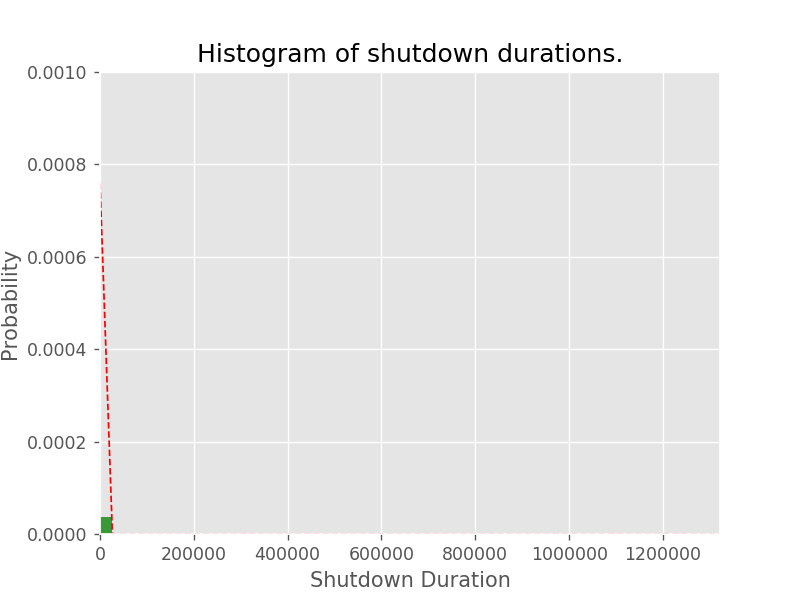

In [106]:
mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(dfOD.duration, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Shutdown Duration')
plt.ylabel('Probability')
plt.title('Histogram of shutdown durations.')
plt.axis([min(dfOD.duration), max(dfOD.duration), 0, 0.001]) #[min x, max x, min y, max y]
plt.grid(True)

plt.show()

In [100]:
print (type(x[0]))#numpy.float64
print (type(x))#numpy.ndarray

<class 'numpy.float64'>
<class 'numpy.ndarray'>


In [102]:
print (max(dfOD.duration))
print (min(dfOD.duration))

1321560.0
60.0


In [113]:
#truncate the shutdowns less tha 5 minutes.
dfODDuration = dfOD.duration
type(dfODDuration)

pandas.core.series.Series

In [114]:
dfODDuration= dfODDuration[dfODDuration>300]

In [118]:
print (dfODDuration.describe())
print (dfODDuration.shape)


count    7.770000e+02
mean     7.445483e+03
std      5.236934e+04
min      3.600000e+02
25%      6.000000e+02
50%      1.200000e+03
75%      3.540000e+03
max      1.321560e+06
Name: duration, dtype: float64
(777,)
